2023-11-08 15:03:08.707503: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
62/62 - 30s - loss: 1.0785 - accuracy: 0.5650
Epoch 2/40
62/62 - 30s - loss: 0.9821 - accuracy: 0.6367
Epoch 3/40
62/62 - 31s - loss: 0.9284 - accuracy: 0.6545
Epoch 4/40
62/62 - 31s - loss: 0.8697 - accuracy: 0.6768
Epoch 5/40
62/62 - 31s - loss: 0.8263 - accuracy: 0.6870
Epoch 6/40
62/62 - 31s - loss: 0.7882 - accuracy: 0.7048
Epoch 7/40
62/62 - 32s - loss: 0.7614 - accuracy: 0.7190
Epoch 8/40
62/62 - 32s - loss: 0.7039 - accuracy: 0.7429
Epoch 9/40
62/62 - 31s - loss: 0.6668 - accuracy: 0.7470
Epoch 10/40
62/62 - 32s - loss: 0.5919 - accuracy: 0.7830
Epoch 11/40
62/62 - 32s - loss: 0.5519 - accuracy: 0.7937
Epoch 12/40
62/62 - 31s - loss: 0.5007 - accuracy: 0.8115
Epoch 13/40
62/62 - 31s - loss: 0.4781 - accuracy: 0.8293
Epoch 14/40
62/62 - 32s - loss: 0.3971 - accuracy: 0.8501
Epoch 15/40
62/62 - 32s - loss: 0.3772 - accuracy: 0.8567
Epoch 16/40
62/62 - 31s - loss: 0.3740 - accuracy: 0.8684
Epoch 17/40
62/62 - 31s - loss: 0.3215 - accuracy: 0.8847
Epoch 18/40
62/62 - 31s

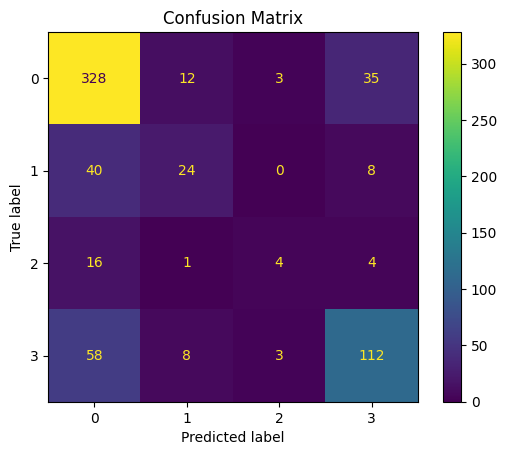

Classification report for Mono:
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       139
           1       0.75      0.26      0.39        34
           2       0.38      0.21      0.27        14
           3       0.81      0.71      0.76        76

    accuracy                           0.74       263
   macro avg       0.66      0.53      0.56       263
weighted avg       0.73      0.74      0.71       263


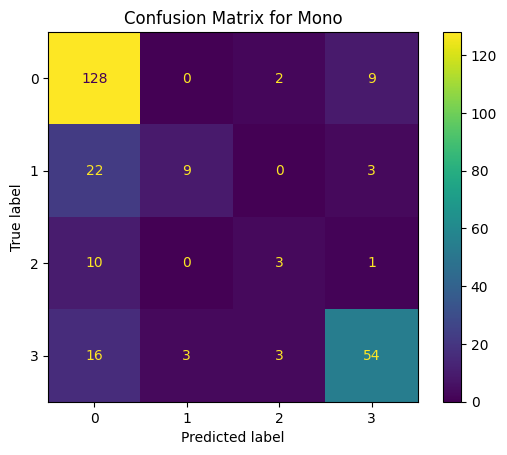

Classification report for Poly:
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       239
           1       0.45      0.39      0.42        38
           2       0.50      0.09      0.15        11
           3       0.63      0.55      0.59       105

    accuracy                           0.70       393
   macro avg       0.58      0.47      0.49       393
weighted avg       0.68      0.70      0.68       393


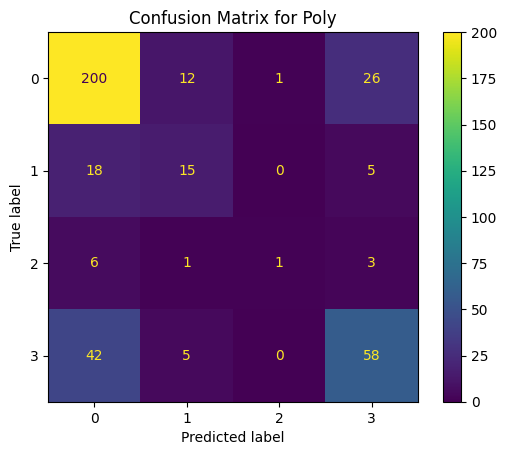

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.python.keras.optimizers import adam_v2
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.python.keras.utils.np_utils import to_categorical
from elpv_dataset.utils.elpv_reader import load_dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


# reduce noise method
def reduce_noise(img):
    return cv2.GaussianBlur(img, (3, 3), 0)


# equalize histogram method
def equalize_histogram(image):
    return cv2.equalizeHist(image)


# Load the dataset
images, proba, types = load_dataset()
# Shuffle and split the dataset
indexes = np.arange(images.shape[0])
np.random.shuffle(indexes)
images = images[indexes]
proba = proba[indexes]
types = types[indexes]

# test size is 1/4
train_images, test_images, train_proba, test_proba, train_types, test_types = train_test_split(
    images, proba, types, test_size=0.25, random_state=42)

# due to the unique labels in proba is 0,1/3,2/3,1,so we should multiply 3.
train_labels = (train_proba * 3).astype(int)
test_labels = (test_proba * 3).astype(int)

num_classes = 4
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# reduce noise
train_images = np.array([reduce_noise(img) for img in train_images])
test_images = np.array([reduce_noise(img) for img in test_images])

# histogram
train_images = np.array([equalize_histogram(img) for img in train_images.reshape(-1, 300, 300)])
test_images = np.array([equalize_histogram(img) for img in test_images.reshape(-1, 300, 300)])

train_images = train_images.reshape(train_images.shape)
test_images = test_images.reshape(test_images.shape)

# Normalization
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape images to make sure they are in the right shape
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)

# Define a CNN Model which has 4 convolutional layers,
# 4 max pooling layers,2 dense layers(one of them is an output layer),
# one input layer, one dropout layer and one flatten layer.
# To prevent overfitting,I added a dropout layer and set rate is 0.5
# which means about half of the neurons will be dropped out.
# Due to hardware limitations, I cannot implement a more complex neural network
# So I will analyze it based on my homemade neural network.
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 1)),
    MaxPooling2D(pool_size=(2, 2), padding='same'),  # Adding padding='same'

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model,use Adam Optimizer.set learning rate = 0.001
learning_rate = 0.001
optimizer = adam_v2.Adam(learning_rate=learning_rate)
model.compile(optimizer=adam_v2.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to the training data.Due to hardware limitations,I set 40 epochs.
epochs = 40
batch_size = 32
verbose = 2
model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, verbose=verbose)

# show test loss and test accuracy
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_accuracy)

# Evaluate the model on the test data
test_labels = np.argmax(test_labels, axis=1)
predictions = np.argmax(model.predict(test_images), axis=-1)

# Generate classification report
print(classification_report(test_labels, predictions, zero_division=1))

# Display confusion matrix
cm = confusion_matrix(test_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# create masks for mono and poly and then predict
mono_mask = (test_types == 'mono')
poly_mask = (test_types == 'poly')
mono_images = test_images[mono_mask]
poly_images = test_images[poly_mask]
mono_labels = test_labels[mono_mask]
poly_labels = test_labels[poly_mask]
mono_predictions = model.predict(mono_images)
mono_predictions = np.argmax(mono_predictions, axis=1)
poly_predictions = model.predict(poly_images)
poly_predictions = np.argmax(poly_predictions, axis=1)

# report and matrix for mono
print("Classification report for Mono:")
print(classification_report(mono_labels, mono_predictions, zero_division=1))
confusion_matrix_mono = confusion_matrix(mono_labels, mono_predictions)
disp_mono = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_mono)
disp_mono.plot()
plt.title('Confusion Matrix for Mono')
plt.show()

# report and matrix for poly
print("Classification report for Poly:")
print(classification_report(poly_labels, poly_predictions, zero_division=1))
cm_poly = confusion_matrix(poly_labels, poly_predictions)
disp_poly = ConfusionMatrixDisplay(confusion_matrix=cm_poly)
disp_poly.plot()
plt.title('Confusion Matrix for Poly')
plt.show()
